<a href="https://colab.research.google.com/github/ArmanBehi/Autoencoder_cFOS/blob/main/cFOS_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries


In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# NEW! for getting summary info on models
from torchsummary import summary

#For importing images
from PIL import Image
import numpy as np
import os
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-2-cd8e32fba56d>:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


#Mount Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import your Google Drive path


In [ ]:
from IPython.display import display, HTML

# Define CSS styles for the input box
input_style = """
    border: 2px solid #0074D9;
    padding: 10px;
    border-radius: 5px;
    font-size: 16px;
    width: 300px;
    outline: none;
    margin: 10px;
"""

# Display an input box with the specified style
input_html = f'<input style="{input_style}" placeholder="Enter your input here" id="input-box">'
display(HTML(input_html))

# Get user input
data_folder= input("Enter your the path of your Original images: ")
test_folder=input("Enter your the path of your modified images:")

  # number of epochs
  numepochs = input("number of epochs:")

# You can access the user's input using the variable 'user_input'
print(f'You entered: {user_input}')


#Importing Training data
The images must be ordered as follow:

  parent folder:

       Group1
       .
       .
       .
       Group2
       .
       .
       .

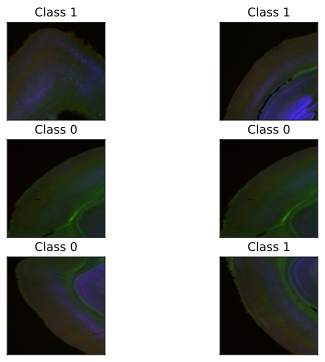

In [ ]:
# Predefines image uploading pixel
imgSize = 1000


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor()
])

# Create a custom dataset using ImageFolder and apply the transformation
custom_dataset = datasets.ImageFolder(root=data_folder, transform=transform)

# Create a DataLoader to iterate through the dataset
data_loader = DataLoader(custom_dataset, batch_size=len(custom_dataset), shuffle=False)

# Iterate through the DataLoader to get images and labels
for images, labels in data_loader:
    # images will be a tensor of shape (batch_size, 3, imgSize, imgSize)
    # labels will be a tensor of shape (batch_size,)
    pass

# Display images in Colab
fig, axs = plt.subplots(3, 2, figsize=(7, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(len(images))  # Randomly choose an index
    image = np.squeeze(images[whichpic, :, :, :])  # Access the first (and only) channel

    ax.imshow(image.permute(1, 2, 0), vmin=0, vmax=1)
    ax.set_title('Class %s' % int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#Create a class for the model

In [ ]:
def makeTheNet():

  class cFOSnet(nn.Module):
    def __init__(self):
      super().__init__()

      # Encoder
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input: [3, 1000, 1000], Output: [16, 1000, 1000]
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),  # Input: [16, 1000, 1000], Output: [16, 500, 500]
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Input: [16, 500, 500], Output: [32, 500, 500]
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)  # Input: [32, 500, 500], Output: [32, 250, 250]
      )

      # Decoder
      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # Input: [32, 250, 250], Output: [16, 250, 250]
          nn.ReLU(),
          nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  # Input: [16, 250, 250], Output: [3, 250, 250]
          nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),  # Upsample to [3, 500, 500]
          nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1, padding=1),  # Input: [3, 500, 500], Output: [3, 500, 500]
          # nn.Sigmoid()  # To squash the values between 0 and 1
      )

    def forward(self,x):
      return self.decoder( self.encoder(x) )

  # create the model instance
  net = cFOSnet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# a function that trains the model

In [ ]:
def function2trainTheModel():


  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(len(images[:,0,1,1]),size=3,replace=False)
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

#Running the model

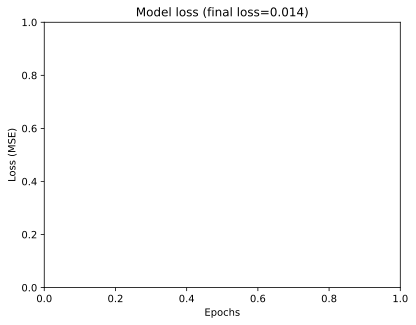

In [ ]:
losses,net = function2trainTheModel()

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

#visualize some images

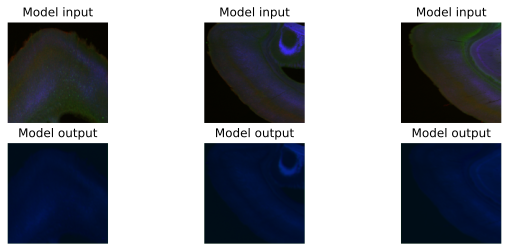

In [ ]:
pics2use = np.random.choice(len(images[:,0,1,1]),size=3,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,3,figsize=(10,4))

for i in range(3):

  G = torch.squeeze( X[i,:,:,:] ).detach()
  O = torch.squeeze( yHat[i,:,:,:] ).detach()

  axs[0,i].imshow(G.permute(1, 2, 0), vmin=-1, vmax=1, cmap='binary')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O.permute(1, 2, 0), vmin=-1, vmax=1, cmap='binary')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

In [1]:
from IPython.display import display, HTML

# Define CSS styles for the input box
input_style = """
    border: 2px solid #0074D9;
    padding: 10px;
    border-radius: 5px;
    font-size: 16px;
    width: 300px;
    outline: none;
    margin: 10px;
"""

# Display an input box with the specified style
input_html = f'<input style="{input_style}" placeholder="Enter your input here" id="input-box">'
display(HTML(input_html))

# Get user input
user_input = input("Enter your input: ")

# You can access the user's input using the variable 'user_input'
print(f'You entered: {user_input}')


KeyboardInterrupt: Interrupted by user